In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

2025-06-07 20:55:56.195643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749329756.214632   11848 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749329756.220475   11848 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 20:55:56.241209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train = pd.read_csv("train_QNN.csv")
val = pd.read_csv("val_QNN.csv")
test = pd.read_csv("test_QNN.csv")

In [4]:
X_train = train.drop(columns=['category', 'ataque_original'])
y_train = train['category']
label_train = train['ataque_original']

X_test = test.drop(columns=['category', 'ataque_original'])
y_test = test['category']
label_test = test['ataque_original']

X_val = val.drop(columns=['category', 'ataque_original'])
y_val = val['category']
label_val = val['ataque_original']

In [5]:
X_train.shape, X_test.shape, X_val.shape

((223572, 15), (63881, 15), (31939, 15))

In [6]:
# Normalización del conjunto de datos
norm = StandardScaler()

X_train = norm.fit_transform(X_train)
X_val = norm.transform(X_val)
X_test = norm.transform(X_test)

# Etiquetas codificadas
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

y_train = to_categorical(y_train_enc, num_classes=2)
y_val = to_categorical(y_val_enc, num_classes=2)
y_test = to_categorical(y_test_enc, num_classes=2)

In [7]:
model_filepath = 'Model15Feat/model-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    #verbose = 1
)

In [8]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(16, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch = 200
steps_per_epoch = len(X_train) // batch
validation_steps = len(X_val) // batch

# Entrenar el modelo
history = model.fit(X_train,
                    y_train,
                    epochs=200, batch_size=batch,
                    validation_data=(X_val, y_val),
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    callbacks=[checkpoint])


/home/iraizozj/entorno/entorno/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749329778.390874   11848 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 873 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
I0000 00:00:1749329778.392557   11848 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 35107 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1749329778.394047   11848 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38064 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB,

Epoch 1/200


I0000 00:00:1749329779.706303  271687 service.cc:148] XLA service 0x7fab6c00b210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749329779.706332  271687 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1749329779.706336  271687 service.cc:156]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1749329779.706339  271687 service.cc:156]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1749329779.706342  271687 service.cc:156]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-06-07 20:56:19.739982: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749329779.846023  271687 cuda_dnn.cc:529] Loaded cuDNN version 90300


  97/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5824 - loss: 0.7208

I0000 00:00:1749329781.317564  271687 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1117/1117 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7725 - loss: 0.5238 - val_accuracy: 0.9181 - val_loss: 0.2945
Epoch 2/200
   1/1117 ━━━━━━━━━━━━━━━━━━━━ 28:39 2s/step - accuracy: 0.9070 - loss: 0.3236

/home/iraizozj/entorno/entorno/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step - accuracy: 0.9070 - loss: 0.3236 - val_accuracy: 0.9186 - val_loss: 0.2945
Epoch 3/200
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8980 - loss: 0.3184 - val_accuracy: 0.9244 - val_loss: 0.2712
Epoch 4/200
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - accuracy: 0.9244 - loss: 0.2221 - val_accuracy: 0.9245 - val_loss: 0.2711
Epoch 5/200
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9120 - loss: 0.2885 - val_accuracy: 0.9260 - val_loss: 0.2577
Epoch 6/200
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - accuracy: 0.9302 - loss: 0.2526 - val_accuracy: 0.9262 - val_loss: 0.2576
Epoch 7/200
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9170 - loss: 0.2777 - val_accuracy: 0.9267 - val_loss: 0.2484
Epoch 8/200
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.8895 - loss: 0.3294 - val_accuracy: 0.9267 - val_loss: 0.2485
Epoch 9/200
1117/1117 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9204 - loss: 0.270

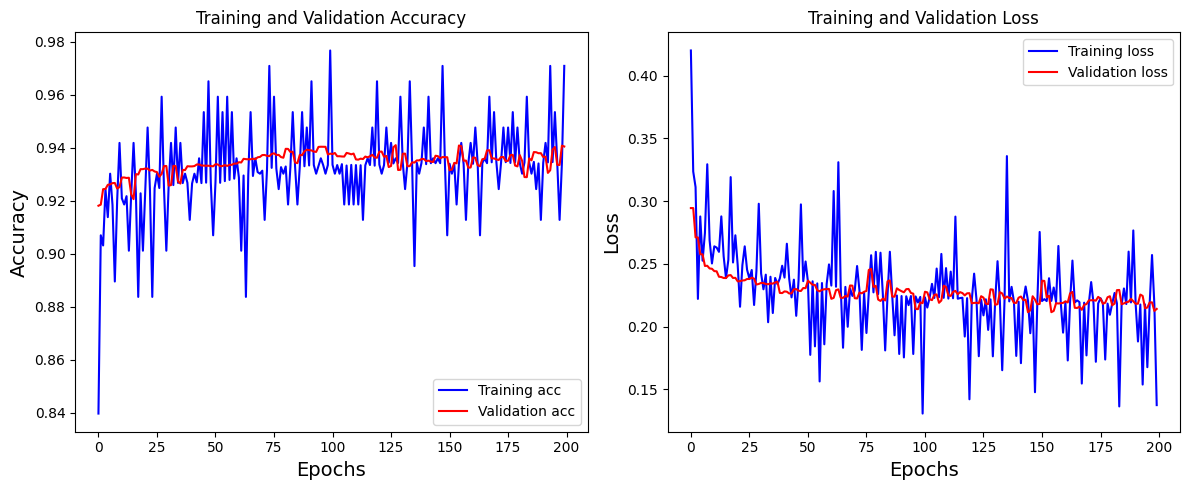

In [16]:
import matplotlib.pyplot as plt

# Datos
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Crear figura y subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax1.plot(epochs, acc, 'b', label='Training acc')
ax1.plot(epochs, val_acc, 'r', label='Validation acc')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend()

# Loss
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.legend()

# Ajuste de espaciado y guardado
plt.tight_layout()
plt.savefig('NN1_train.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [12]:
#Importamos el modelo con mayor accuracy en validacion
MLP1 = load_model('Model15Feat/model-128-0.9410.keras')

In [13]:
y_pred_proba = MLP1.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

1997/1997 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  


In [14]:
accuracy = accuracy_score(y_test_enc, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9401230412798798


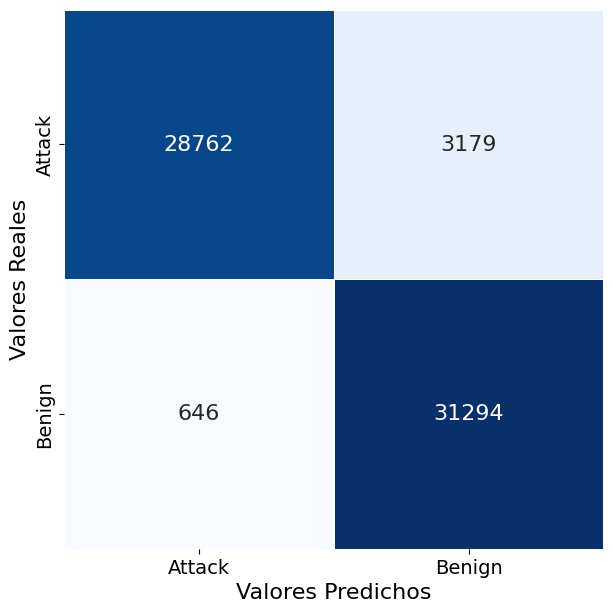

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Confusion matrix
cm = metrics.confusion_matrix(y_test_enc, y_pred)
normalized_matrix = cm  # O normaliza si quieres: cm / cm.sum(axis=1, keepdims=True)

class_names = ['Attack', 'Benign']

# Plot
sns.heatmap(
    normalized_matrix, 
    annot=True, 
    fmt='0.0f', 
    linewidth=0.5,
    annot_kws={"size": 16}, 
    xticklabels=class_names,
    yticklabels=class_names, 
    square=True, 
    cmap='Blues', 
    cbar=False
)

fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.ylabel('Valores Reales', fontsize=16)
plt.xlabel('Valores Predichos', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Guardar como PDF (¡hazlo antes del plt.show!)
plt.savefig('CM_MLP_15car_2ClassFull.pdf', format='pdf', bbox_inches='tight')

plt.show()


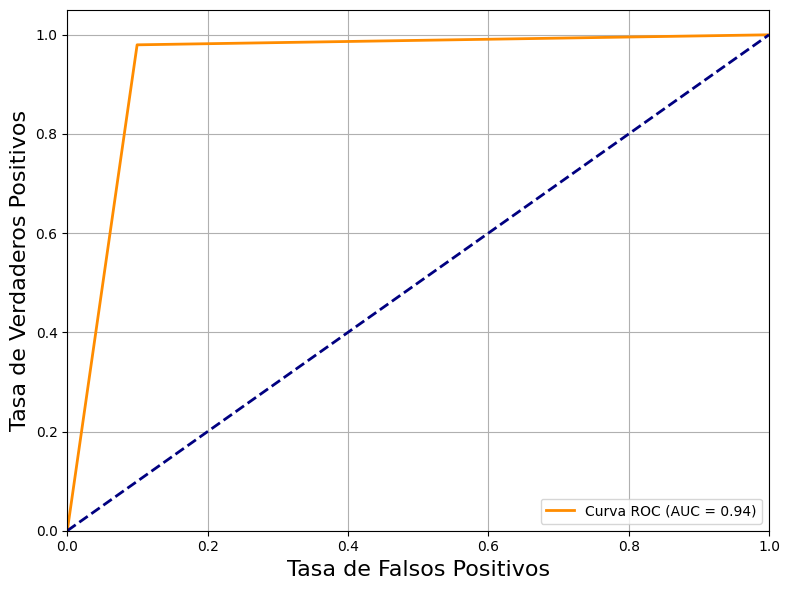

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC (usando las probabilidades de la clase positiva)
fpr, tpr, thresholds = roc_curve(y_test_enc, y_pred)  # ← y_pred_proba, no y_pred
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=16)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=16)
#plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC_MLP_15car_2ClassFull.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
genuinos = []
impostores = []

for i in range(len(y_test_enc)):
    etiqueta_real = y_test_enc[i] 
    prob_predicha = y_pred_proba[i] 
    
    score_genuino = prob_predicha[etiqueta_real]
    scores_impostores = np.delete(prob_predicha, etiqueta_real)

    genuinos.append(score_genuino)
    impostores.extend(scores_impostores)

genuinos = np.array(genuinos)
impostores = np.array(impostores)

print("Genuinos:", genuinos.shape)
print("Impostores:", impostores.shape)


Genuinos: (63881,)
Impostores: (63881,)


In [41]:
thresholds = np.arange(0, 1.001, 0.001)
FAR = []
FRR = []
for threshold in thresholds:
    FAR.append(np.sum(impostores >= threshold) / len(impostores))
    FRR.append(np.sum(genuinos < threshold) / len(genuinos))

# Imprimir FAR, FRR y AUC
print("FAR:", FAR)
print("FRR:", FRR)

FAR: [np.float64(1.0), np.float64(0.7321269234983798), np.float64(0.7218421752946885), np.float64(0.7211064322725067), np.float64(0.7199010660446769), np.float64(0.7185391587482977), np.float64(0.7167232823531253), np.float64(0.7147195566756939), np.float64(0.696372943441712), np.float64(0.6935082418872591), np.float64(0.6916297490646671), np.float64(0.6595075217983438), np.float64(0.6557974984737246), np.float64(0.6528232181712872), np.float64(0.6503185610744979), np.float64(0.6482209107559368), np.float64(0.6459354111551165), np.float64(0.6439943019051048), np.float64(0.6422253878304973), np.float64(0.637607426308292), np.float64(0.6216089291025501), np.float64(0.6202000594856061), np.float64(0.6185563782658381), np.float64(0.6171944709694588), np.float64(0.6156290602839655), np.float64(0.6140636495984721), np.float64(0.612701742302093), np.float64(0.611277218578294), np.float64(0.6101814310984487), np.float64(0.6091326059391682), np.float64(0.6081150889935975), np.float64(0.60689406

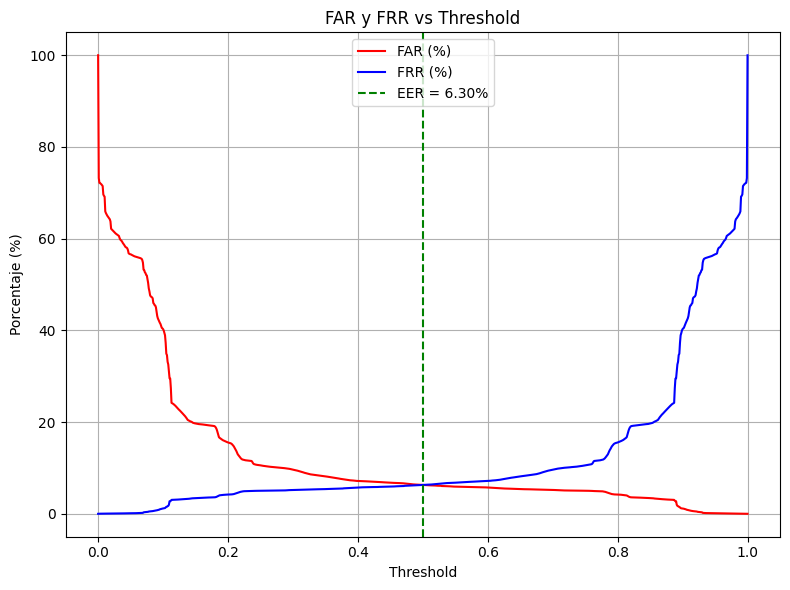

In [45]:
import matplotlib.pyplot as plt
import numpy as np

FAR_porcentaje = np.array(FAR) * 100
FRR_porcentaje = np.array(FRR) * 100

# Calcular EER
eer_threshold_index = np.nanargmin(np.abs(FAR_porcentaje - FRR_porcentaje))
eer_threshold = thresholds[eer_threshold_index]
eer = FAR_porcentaje[eer_threshold_index]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, FAR_porcentaje, label='FAR (%)', color='red')
plt.plot(thresholds, FRR_porcentaje, label='FRR (%)', color='blue')
plt.axvline(eer_threshold, color='green', linestyle='--', label=f'EER = {eer:.2f}%')

plt.xlabel('Threshold')
plt.ylabel('Porcentaje (%)')
plt.title('FAR y FRR vs Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('FAR_FRR_MLP_15car_2ClassFull.pdf', format='pdf', bbox_inches='tight')
plt.show()
